# Загрузка модулей и библиотек

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [65]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense,  Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import AdditiveAttention, Concatenate
from tensorflow.keras.layers import TimeDistributed, Bidirectional, AdditiveAttention, Reshape
from tensorflow.keras.layers import MultiHeadAttention



from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping

# Формируем базовый датасет df_calc_sec_2

In [3]:
from google.colab import files

uploaded = files.upload()

Saving df_calc_sec_2.parquet to df_calc_sec_2.parquet


In [59]:
# Подгружвем df_14 если было автоматическое прерываение работы колаба
df = pd.read_parquet('/content/df_calc_sec_2.parquet')

# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
df = df.drop(columns=['mode'])

Функции нормализации и денормализации данных

In [60]:
# Глобальная переменная скейлера для нормализации и денормализации
scaler = MinMaxScaler(feature_range=(0, 1))

# Функция нормализации данных
def normalize_data(values):
    """Преобразует данные в диапазон [0, 1]"""
    global scaler
    scaled_values = scaler.fit_transform(values.reshape(-1, 1))
    return scaled_values.flatten()

# Функция денормализации данных
def denormalize_data(scaled_values):
    """Восстанавливает оригинальные значения из нормализованных"""
    global scaler
    original_values = scaler.inverse_transform(scaled_values.reshape(-1, 1))
    return original_values.flatten()

Функция формирования выборки

In [61]:
# Функция подготовки данных
def prepare_data(arr, look_back=10, n_output_steps=120):
    """
    Функция подготовки данных для временного ряда.
    :param arr: Массив временных данных
    :param look_back: Сколько шагов назад смотрит модель
    :param n_output_steps: Сколько шагов вперед прогнозировать
    :return: Входные (X) и выходные (Y) данные
    """
    X, Y = [], []
    for i in range(len(arr)-look_back-n_output_steps+1):
        seq_in = arr[i:i+look_back]
        seq_out = arr[i+look_back:i+look_back+n_output_steps]
        X.append(seq_in)
        Y.append(seq_out)
    X_array = np.array(X)
    Y_array = np.array(Y)
    print("Shapes after preparation:")
    print("X:", X_array.shape)
    print("Y:", Y_array.shape)
    return X_array, Y_array

Арихтектура модели

In [62]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

# Вариант 1: увеличили период обучения до 3 мес.

Подготовка данных

In [71]:
# Ограничиваем диапазон дат
start_date = '2024-06-01'
end_date = '2024-09-01'

# Ограничиваем датасет периодом обучения
df = df[(df['source_time'] >= start_date) & (df['source_time'] <= end_date)]

# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
#df = df.drop(columns=['mode'])


# Основные настройки
look_back = 10            # Сколько шагов назад смотрим
n_features = 1            # Всего один признак (одно измерение временного ряда)
#lags = [20, 30, 40, 60, 90, 120]  # Лаги для экспериментов
lags = [20]

# Определяем целевую переменную
values = df["value_14"].values

# Нормализация данных
scaled_values = normalize_data(values)

Обучение и тестирование модели



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)

Shapes before training:
X_train: (211945, 10)
Y_train: (211945, 20)
X_val: (52987, 10)
Y_val: (52987, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 120s 35ms/step - loss: 0.0155 - mae: 0.0700 - val_loss: 0.0109 - val_mae: 0.0572
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 139s 34ms/step - loss: 0.0110 - mae: 0.0582 - val_loss: 0.0107 - val_mae: 0.0604
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 141s 34ms/step - loss: 0.0107 - mae: 0.0577 - val_loss: 0.0105 - val_mae: 0.0569
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 145s 34ms/step - loss: 0.0106 - mae: 0.0564 - val_loss: 0.0117 - val_mae: 0.0637
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 111s 34ms/step - loss: 0.0106 - mae: 0.0562 - val_loss: 0.0103 - val_mae: 0.0596
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 34ms/step - loss: 0.0106 - mae: 0.0566 - val_loss: 0.0105 - val_mae: 0.0624
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 112s 34ms/step - l

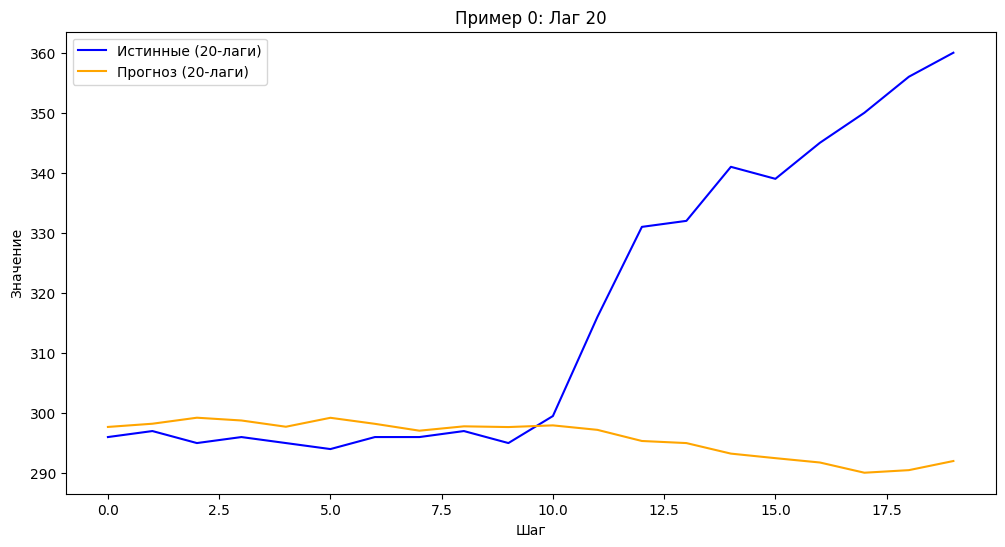

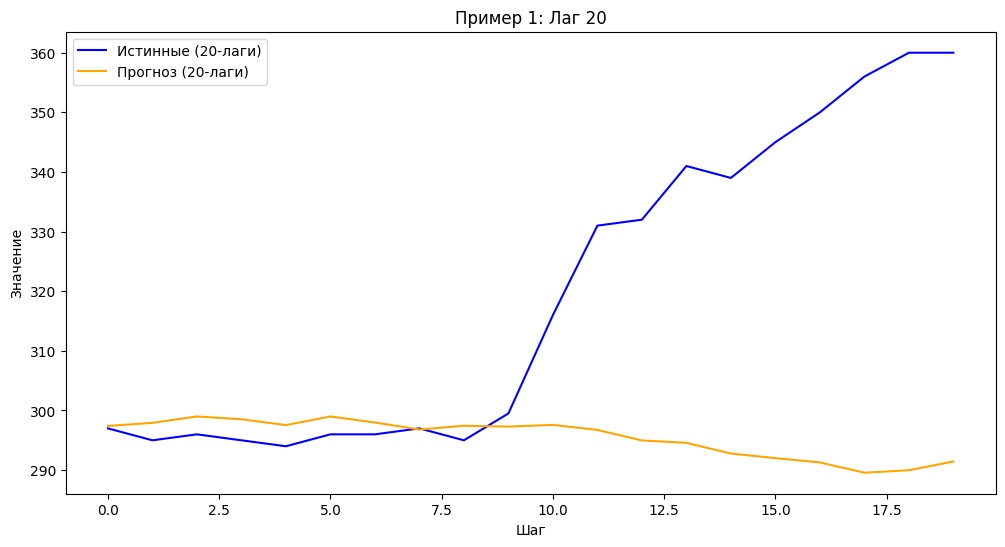

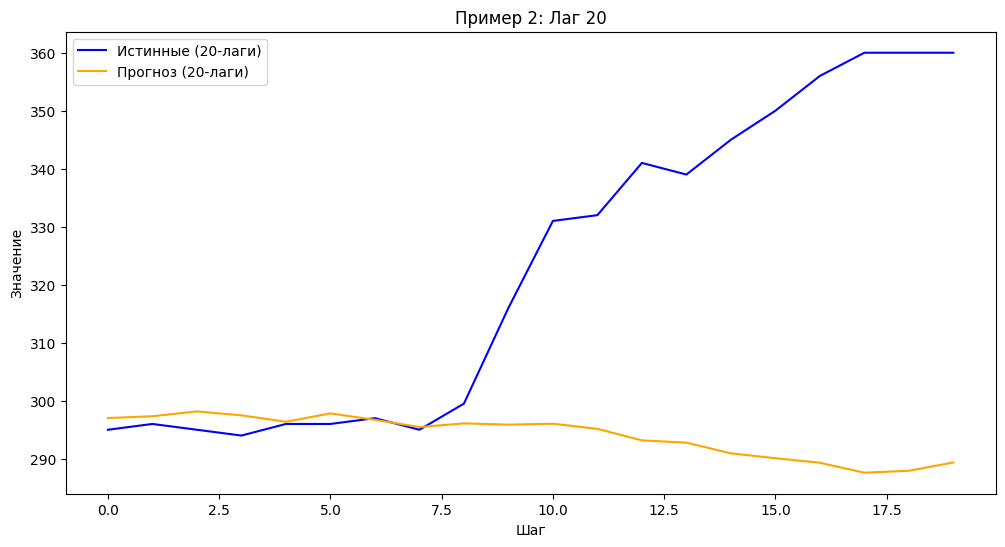

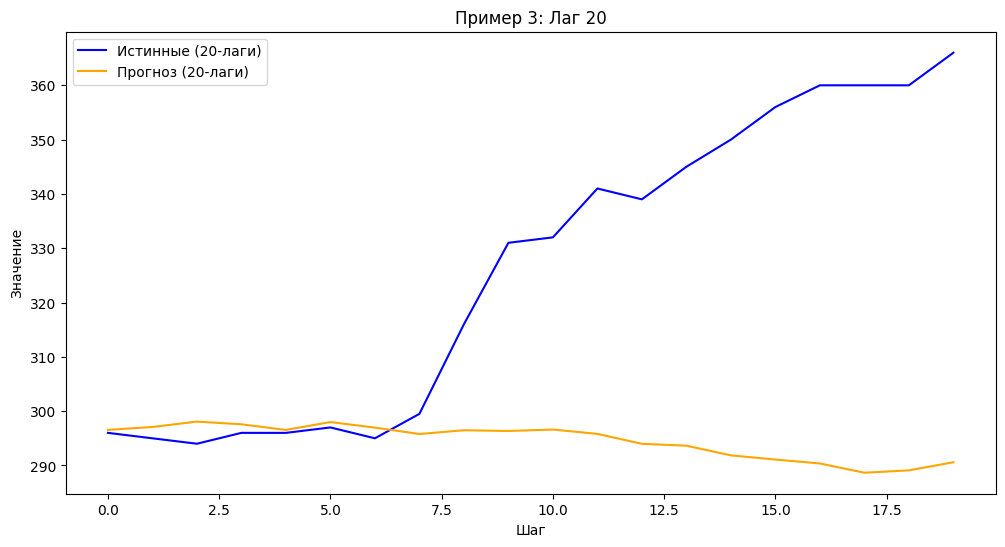

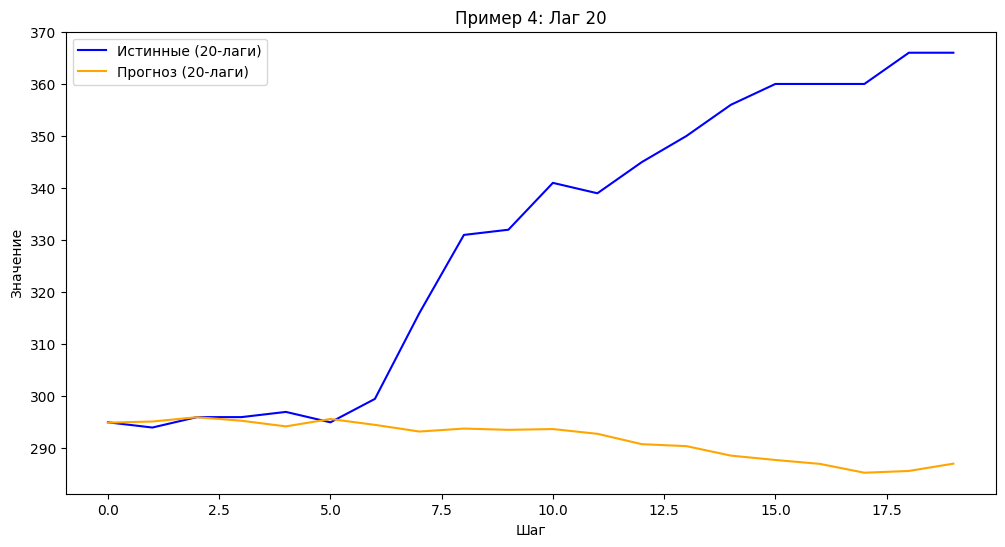

1656/1656 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step

Final evaluation shapes:
Y_val flattened: (1059740,)
Predicted values flattened: (1059740,)
Среднее абсолютное отклонение (MAE) для лагов 20: 31.0761



In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]
    print("\nShapes before training:")
    print("X_train:", X_train.shape)
    print("Y_train:", Y_train.shape)
    print("X_val:", X_val.shape)
    print("Y_val:", Y_val.shape)

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)
    for idx in range(min(5, len(predictions))):
        true_values = Y_val[idx].flatten()
        pred_values = predictions[idx].flatten()

        # Возвращаем к оригинальной шкале
        true_denorm = denormalize_data(true_values)
        pred_denorm = denormalize_data(pred_values)

        plt.figure(figsize=(12, 6))
        plt.plot(true_denorm, label=f'Истинные ({lag}-лаги)', color='blue')
        plt.plot(pred_denorm, label=f'Прогноз ({lag}-лаги)', color='orange')
        plt.xlabel('Шаг')
        plt.ylabel('Значение')
        plt.title(f'Пример {idx}: Лаг {lag}')
        plt.legend()
        plt.show()

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")

# Вариант 2: изменили оптимизатор
optimizer = RMSprop(learning_rate=0.001)


In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    optimizer = RMSprop(learning_rate=0.001)
    #optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]
    print("\nShapes before training:")
    print("X_train:", X_train.shape)
    print("Y_train:", Y_train.shape)
    print("X_val:", X_val.shape)
    print("Y_val:", Y_val.shape)

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)

Shapes before training:
X_train: (211945, 10)
Y_train: (211945, 20)
X_val: (52987, 10)
Y_val: (52987, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 117s 34ms/step - loss: 0.0152 - mae: 0.0696 - val_loss: 0.0114 - val_mae: 0.0683
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 174s 43ms/step - loss: 0.0107 - mae: 0.0574 - val_loss: 0.0125 - val_mae: 0.0661
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 125s 38ms/step - loss: 0.0108 - mae: 0.0573 - val_loss: 0.0107 - val_mae: 0.0623
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 113s 34ms/step - loss: 0.0107 - mae: 0.0573 - val_loss: 0.0106 - val_mae: 0.0597
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 142s 34ms/step - loss: 0.0107 - mae: 0.0568 - val_loss: 0.0106 - val_mae: 0.0550
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms/step - loss: 0.0105 - mae: 0.0560 - val_loss: 0.0110 - val_mae: 0.0610
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 146s 35ms/step - l

# Вариант 3: добавили фильтры в Conv1D
conv = Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu')(inputs)

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]
    print("\nShapes before training:")
    print("X_train:", X_train.shape)
    print("Y_train:", Y_train.shape)
    print("X_val:", X_val.shape)
    print("Y_val:", Y_val.shape)

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)

Shapes before training:
X_train: (211945, 10)
Y_train: (211945, 20)
X_val: (52987, 10)
Y_val: (52987, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 130s 38ms/step - loss: 0.0152 - mae: 0.0696 - val_loss: 0.0109 - val_mae: 0.0572
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 124s 37ms/step - loss: 0.0111 - mae: 0.0588 - val_loss: 0.0110 - val_mae: 0.0548
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - loss: 0.0107 - mae: 0.0572 - val_loss: 0.0110 - val_mae: 0.0615
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 125s 38ms/step - loss: 0.0106 - mae: 0.0566 - val_loss: 0.0108 - val_mae: 0.0630
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 141s 37ms/step - loss: 0.0106 - mae: 0.0568 - val_loss: 0.0106 - val_mae: 0.0590
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 38ms/step - loss: 0.0105 - mae: 0.0561 - val_loss: 0.0105 - val_mae: 0.0560
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 139s 37ms/step - l

# Вариант 4: добавили фильтры в Conv1D

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=256, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 167s 49ms/step - loss: 0.0150 - mae: 0.0693 - val_loss: 0.0110 - val_mae: 0.0635
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 198s 48ms/step - loss: 0.0110 - mae: 0.0585 - val_loss: 0.0109 - val_mae: 0.0610
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 192s 45ms/step - loss: 0.0109 - mae: 0.0582 - val_loss: 0.0115 - val_mae: 0.0712
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 214s 49ms/step - loss: 0.0106 - mae: 0.0570 - val_loss: 0.0107 - val_mae: 0.0657
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 157s 47ms/step - loss: 0.0106 - mae: 0.0565 - val_loss: 0.0107 - val_mae: 0.0548
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 152s 46ms/step - loss: 0.0106 - mae: 0.0566 - val_loss: 0.0104 - val_mae: 0.0575
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 209s 48ms/step - loss: 0.0104 - mae: 0.0556 - val_loss: 0.0102 - val_mae: 0.0571
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 15

# Вариант 5: добавили второй слой Conv1D

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Первый конволюционный слой
    conv1 = Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Второй конволюционный слой
    conv2 = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool2)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 83s 23ms/step - loss: 0.0194 - mae: 0.0822 - val_loss: 0.0146 - val_mae: 0.0888
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 77s 22ms/step - loss: 0.0128 - mae: 0.0654 - val_loss: 0.0128 - val_mae: 0.0657
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - loss: 0.0125 - mae: 0.0642 - val_loss: 0.0129 - val_mae: 0.0654
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 70s 21ms/step - loss: 0.0124 - mae: 0.0634 - val_loss: 0.0125 - val_mae: 0.0685
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 72s 22ms/step - loss: 0.0121 - mae: 0.0625 - val_loss: 0.0133 - val_mae: 0.0708
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - loss: 0.0121 - mae: 0.0622 - val_loss: 0.0125 - val_mae: 0.0629
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 71s 21ms/step - loss: 0.0120 - mae: 0.0619 - val_loss: 0.0121 - val_mae: 0.0663
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/

# Вариант 6: добавили второй слой LSTM

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    conv1 = Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    # Подключаемся к первому bi-LSTM
    lstm1 = Bidirectional(LSTM(128, return_sequences=True))(pool1)
    drop1 = Dropout(0.3)(lstm1)

    # Второй слой bi-LSTM
    lstm2 = Bidirectional(LSTM(64, return_sequences=True))(drop1)
    drop2 = Dropout(0.3)(lstm2)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop2, drop2])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 211s 62ms/step - loss: 0.0157 - mae: 0.0736 - val_loss: 0.0115 - val_mae: 0.0692
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 210s 64ms/step - loss: 0.0112 - mae: 0.0604 - val_loss: 0.0112 - val_mae: 0.0594
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 199s 60ms/step - loss: 0.0109 - mae: 0.0587 - val_loss: 0.0108 - val_mae: 0.0542
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 202s 61ms/step - loss: 0.0107 - mae: 0.0580 - val_loss: 0.0109 - val_mae: 0.0630
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 207s 63ms/step - loss: 0.0106 - mae: 0.0572 - val_loss: 0.0106 - val_mae: 0.0618
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 267s 64ms/step - loss: 0.0106 - mae: 0.0570 - val_loss: 0.0107 - val_mae: 0.0571
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 262s 64ms/step - loss: 0.0103 - mae: 0.0558 - val_loss: 0.0104 - val_mae: 0.0585
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 21

# Вариант 7: добавили юниты в слой LSTM

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=256, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 162s 47ms/step - loss: 0.0148 - mae: 0.0693 - val_loss: 0.0113 - val_mae: 0.0689
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 165s 50ms/step - loss: 0.0109 - mae: 0.0582 - val_loss: 0.0109 - val_mae: 0.0638
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 189s 46ms/step - loss: 0.0109 - mae: 0.0581 - val_loss: 0.0108 - val_mae: 0.0557
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 201s 46ms/step - loss: 0.0108 - mae: 0.0573 - val_loss: 0.0105 - val_mae: 0.0589
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 202s 46ms/step - loss: 0.0106 - mae: 0.0566 - val_loss: 0.0105 - val_mae: 0.0579
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 211s 49ms/step - loss: 0.0105 - mae: 0.0564 - val_loss: 0.0103 - val_mae: 0.0597
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 153s 46ms/step - loss: 0.0105 - mae: 0.0561 - val_loss: 0.0103 - val_mae: 0.0565
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 21

# Вариант 8: увеличили ядро Conv1D до 5

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 136s 39ms/step - loss: 0.0151 - mae: 0.0697 - val_loss: 0.0113 - val_mae: 0.0610
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 128s 39ms/step - loss: 0.0109 - mae: 0.0577 - val_loss: 0.0109 - val_mae: 0.0619
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 129s 39ms/step - loss: 0.0108 - mae: 0.0574 - val_loss: 0.0114 - val_mae: 0.0610
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 139s 38ms/step - loss: 0.0109 - mae: 0.0579 - val_loss: 0.0109 - val_mae: 0.0613
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 129s 39ms/step - loss: 0.0106 - mae: 0.0565 - val_loss: 0.0107 - val_mae: 0.0638
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 141s 39ms/step - loss: 0.0106 - mae: 0.0564 - val_loss: 0.0107 - val_mae: 0.0600
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 39ms/step - loss: 0.0105 - mae: 0.0559 - val_loss: 0.0105 - val_mae: 0.0587
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 14

# Вариант 9: увеличили ядро Conv1D до 7, увеличили фильтр до 256 и размер пулинга до 3

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=256, kernel_size=7, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=3)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 115s 34ms/step - loss: 0.0170 - mae: 0.0754 - val_loss: 0.0121 - val_mae: 0.0625
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 109s 33ms/step - loss: 0.0118 - mae: 0.0613 - val_loss: 0.0120 - val_mae: 0.0617
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 141s 33ms/step - loss: 0.0117 - mae: 0.0608 - val_loss: 0.0117 - val_mae: 0.0686
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 110s 33ms/step - loss: 0.0114 - mae: 0.0601 - val_loss: 0.0124 - val_mae: 0.0627
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 144s 34ms/step - loss: 0.0115 - mae: 0.0599 - val_loss: 0.0118 - val_mae: 0.0606
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 140s 33ms/step - loss: 0.0114 - mae: 0.0599 - val_loss: 0.0114 - val_mae: 0.0630
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 111s 33ms/step - loss: 0.0113 - mae: 0.0590 - val_loss: 0.0116 - val_mae: 0.0659
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 14

# Вариант 10: увеличили шаг оптимайзера

In [ ]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.0001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 134s 39ms/step - loss: 0.0279 - mae: 0.0940 - val_loss: 0.0115 - val_mae: 0.0575
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 128s 39ms/step - loss: 0.0111 - mae: 0.0576 - val_loss: 0.0111 - val_mae: 0.0623
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 131s 39ms/step - loss: 0.0110 - mae: 0.0569 - val_loss: 0.0109 - val_mae: 0.0590
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 140s 39ms/step - loss: 0.0109 - mae: 0.0564 - val_loss: 0.0112 - val_mae: 0.0560
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 130s 39ms/step - loss: 0.0107 - mae: 0.0560 - val_loss: 0.0109 - val_mae: 0.0582
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 142s 39ms/step - loss: 0.0106 - mae: 0.0556 - val_loss: 0.0107 - val_mae: 0.0567
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 40ms/step - loss: 0.0105 - mae: 0.0552 - val_loss: 0.0106 - val_mae: 0.0594
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 14

# Вариант 11: увеличили размер пулинга до 3 при ядре CNNConv1D 5

In [7]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=3)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Использование механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    # Оптимизатор
    #optimizer = RMSprop(learning_rate=0.001)
    optimizer = Adam(learning_rate=0.001)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

In [12]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 116s 33ms/step - loss: 0.0171 - mae: 0.0759 - val_loss: 0.0121 - val_mae: 0.0689
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 127s 29ms/step - loss: 0.0119 - mae: 0.0619 - val_loss: 0.0123 - val_mae: 0.0608
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 146s 30ms/step - loss: 0.0117 - mae: 0.0610 - val_loss: 0.0123 - val_mae: 0.0652
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 134s 28ms/step - loss: 0.0117 - mae: 0.0607 - val_loss: 0.0114 - val_mae: 0.0601
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 145s 29ms/step - loss: 0.0116 - mae: 0.0603 - val_loss: 0.0118 - val_mae: 0.0577
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 140s 28ms/step - loss: 0.0115 - mae: 0.0596 - val_loss: 0.0115 - val_mae: 0.0662
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 147s 30ms/step - loss: 0.0114 - mae: 0.0596 - val_loss: 0.0113 - val_mae: 0.0608
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 16

# Вариант 12: добавили  объединение результатов внимания и пространства и добавили второй полносвязный слой

In [18]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Последняя полносвязанная сеть для финального вывода
    dense_layer = Dense(128, activation="relu")(Flatten()(spatially_enriched_context))
    output = Dense(n_output_steps)(dense_layer)

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [19]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 133s 39ms/step - loss: 0.0154 - mae: 0.0704 - val_loss: 0.0115 - val_mae: 0.0582
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 120s 36ms/step - loss: 0.0109 - mae: 0.0577 - val_loss: 0.0109 - val_mae: 0.0609
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 139s 35ms/step - loss: 0.0108 - mae: 0.0577 - val_loss: 0.0110 - val_mae: 0.0627
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 142s 35ms/step - loss: 0.0108 - mae: 0.0572 - val_loss: 0.0110 - val_mae: 0.0603
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 144s 36ms/step - loss: 0.0105 - mae: 0.0561 - val_loss: 0.0106 - val_mae: 0.0586
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 36ms/step - loss: 0.0104 - mae: 0.0559 - val_loss: 0.0107 - val_mae: 0.0642
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 117s 35ms/step - loss: 0.0107 - mae: 0.0568 - val_loss: 0.0105 - val_mae: 0.0636
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 13

# Вариант 13: добавили регуляризацию на первом слое Dense

In [29]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Полносвязанные слои для вывода
    dense_layer = Dense(128, activation="relu",
                        kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    output = Dense(n_output_steps)(dense_layer)

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [30]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 134s 39ms/step - loss: 0.0152 - mae: 0.0696 - val_loss: 0.0111 - val_mae: 0.0554
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 128s 35ms/step - loss: 0.0110 - mae: 0.0580 - val_loss: 0.0114 - val_mae: 0.0577
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 118s 36ms/step - loss: 0.0107 - mae: 0.0571 - val_loss: 0.0105 - val_mae: 0.0576
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 138s 34ms/step - loss: 0.0108 - mae: 0.0570 - val_loss: 0.0107 - val_mae: 0.0632
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 35ms/step - loss: 0.0106 - mae: 0.0564 - val_loss: 0.0112 - val_mae: 0.0558
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 35ms/step - loss: 0.0107 - mae: 0.0565 - val_loss: 0.0105 - val_mae: 0.0570
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 142s 35ms/step - loss: 0.0105 - mae: 0.0558 - val_loss: 0.0107 - val_mae: 0.0580
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 14

# Вариант 14: в первом слое Dence изменили функцию активации на 'elu'

In [31]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Полносвязанные слои для вывода
    dense_layer = Dense(128, activation="elu",
                        kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    output = Dense(n_output_steps)(dense_layer)

    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [32]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 138s 37ms/step - loss: 0.0156 - mae: 0.0706 - val_loss: 0.0112 - val_mae: 0.0584
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 137s 36ms/step - loss: 0.0108 - mae: 0.0575 - val_loss: 0.0112 - val_mae: 0.0616
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 143s 36ms/step - loss: 0.0108 - mae: 0.0574 - val_loss: 0.0106 - val_mae: 0.0602
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 119s 36ms/step - loss: 0.0108 - mae: 0.0572 - val_loss: 0.0109 - val_mae: 0.0603
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 144s 36ms/step - loss: 0.0105 - mae: 0.0560 - val_loss: 0.0104 - val_mae: 0.0593
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 142s 37ms/step - loss: 0.0106 - mae: 0.0561 - val_loss: 0.0104 - val_mae: 0.0613
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 141s 36ms/step - loss: 0.0104 - mae: 0.0554 - val_loss: 0.0104 - val_mae: 0.0534
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 14

# Вариант 15: Добавили ещё один слой Dence

In [33]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Два полносвязанных слоя для вывода
    dense_layer_1 = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    dense_layer_2 = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(dense_layer_1)
    output = Dense(n_output_steps)(dense_layer_2)


    # Обычная плотность для прямой регрессии
    output = Dense(n_output_steps)(Flatten()(attention))

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [34]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 127s 37ms/step - loss: 0.0152 - mae: 0.0696 - val_loss: 0.0119 - val_mae: 0.0650
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 139s 36ms/step - loss: 0.0110 - mae: 0.0581 - val_loss: 0.0108 - val_mae: 0.0596
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 164s 42ms/step - loss: 0.0108 - mae: 0.0577 - val_loss: 0.0106 - val_mae: 0.0585
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 123s 37ms/step - loss: 0.0108 - mae: 0.0571 - val_loss: 0.0107 - val_mae: 0.0546
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 141s 36ms/step - loss: 0.0105 - mae: 0.0561 - val_loss: 0.0105 - val_mae: 0.0562
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 153s 46ms/step - loss: 0.0104 - mae: 0.0557 - val_loss: 0.0106 - val_mae: 0.0592
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 169s 36ms/step - loss: 0.0104 - mae: 0.0558 - val_loss: 0.0104 - val_mae: 0.0560
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 14

# Вариант 16: применение механизма многозначного внимания с несколькими головами

In [44]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма многозначного внимания с несколькими головами
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(drop, drop, drop)


    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Два полносвязанных слоя для вывода
    dense_layer_1 = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    dense_layer_2 = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(dense_layer_1)


    # Комбинируем потоки и получаем единый выход
    combined = Concatenate(axis=-1)([Flatten()(attention), dense_layer_2])
    output = Dense(n_output_steps)(combined)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [45]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 389s 115ms/step - loss: 0.2383 - mae: 0.0699 - val_loss: 0.0114 - val_mae: 0.0729
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 428s 111ms/step - loss: 0.0111 - mae: 0.0593 - val_loss: 0.0109 - val_mae: 0.0581
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 370s 112ms/step - loss: 0.0109 - mae: 0.0581 - val_loss: 0.0107 - val_mae: 0.0561
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 384s 113ms/step - loss: 0.0108 - mae: 0.0577 - val_loss: 0.0104 - val_mae: 0.0583
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 378s 111ms/step - loss: 0.0106 - mae: 0.0567 - val_loss: 0.0102 - val_mae: 0.0569
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 381s 111ms/step - loss: 0.0105 - mae: 0.0562 - val_loss: 0.0103 - val_mae: 0.0568
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 384s 112ms/step - loss: 0.0104 - mae: 0.0555 - val_loss: 0.0108 - val_mae: 0.0629
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━

# Вариант 17: исправили ошибку в Dence слое (Комбинируем потоки и получаем единый выход)

In [47]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Два полносвязанных слоя для вывода
    dense_layer_1 = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    dense_layer_2 = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(dense_layer_1)

    # Комбинируем потоки и получаем единый выход
    combined = Concatenate(axis=-1)([Flatten()(attention), dense_layer_2])
    output = Dense(n_output_steps)(combined)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [48]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 173s 50ms/step - loss: 0.2388 - mae: 0.0694 - val_loss: 0.0111 - val_mae: 0.0613
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 198s 49ms/step - loss: 0.0109 - mae: 0.0580 - val_loss: 0.0109 - val_mae: 0.0599
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 185s 44ms/step - loss: 0.0110 - mae: 0.0577 - val_loss: 0.0108 - val_mae: 0.0548
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 150s 45ms/step - loss: 0.0108 - mae: 0.0572 - val_loss: 0.0110 - val_mae: 0.0591
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 209s 47ms/step - loss: 0.0106 - mae: 0.0565 - val_loss: 0.0112 - val_mae: 0.0699
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 191s 44ms/step - loss: 0.0105 - mae: 0.0559 - val_loss: 0.0105 - val_mae: 0.0573
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 203s 44ms/step - loss: 0.0105 - mae: 0.0560 - val_loss: 0.0111 - val_mae: 0.0680
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 20

# Вариант 18: сделали выходной слой Dense(n_output_steps)(dense_layer_2)

In [53]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Полносвязанные слои для вывода
    dense_layer_1 = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    dense_layer_2 = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(dense_layer_1)
    output = Dense(n_output_steps)(dense_layer_2)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [54]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 155s 45ms/step - loss: 0.2479 - mae: 0.0745 - val_loss: 0.0120 - val_mae: 0.0670
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 203s 45ms/step - loss: 0.0119 - mae: 0.0602 - val_loss: 0.0117 - val_mae: 0.0690
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 216s 49ms/step - loss: 0.0115 - mae: 0.0595 - val_loss: 0.0110 - val_mae: 0.0599
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 200s 49ms/step - loss: 0.0114 - mae: 0.0594 - val_loss: 0.0112 - val_mae: 0.0609
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 199s 48ms/step - loss: 0.0112 - mae: 0.0586 - val_loss: 0.0112 - val_mae: 0.0594
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 161s 49ms/step - loss: 0.0111 - mae: 0.0583 - val_loss: 0.0117 - val_mae: 0.0706
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 187s 44ms/step - loss: 0.0110 - mae: 0.0580 - val_loss: 0.0124 - val_mae: 0.0775
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 20

# Вариант 19: сделали выходной слой    
- combined = Concatenate(axis=-1)([Flatten()(attention), dense_layer_2])
- output = Dense(n_output_steps)(combined)

In [55]:
# Архитектура модели
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Конволюционная часть для извлечения признаков
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # Подключаемся к bi-LSTM
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Применение механизма внимания
    attention = AdditiveAttention()([drop, drop])

    # Объединение результатов внимания и пространства
    spatially_enriched_context = Concatenate(axis=-1)([pool, attention])

    # Полносвязанные слои для вывода
    dense_layer_1 = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(Flatten()(spatially_enriched_context))
    dense_layer_2 = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(dense_layer_1)

    # Комбинируем потоки и получаем единый выход
    combined = Concatenate(axis=-1)([Flatten()(attention), dense_layer_2])
    output = Dense(n_output_steps)(combined)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [56]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 180s 53ms/step - loss: 0.2376 - mae: 0.0701 - val_loss: 0.0109 - val_mae: 0.0592
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 152s 46ms/step - loss: 0.0108 - mae: 0.0573 - val_loss: 0.0110 - val_mae: 0.0580
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 207s 48ms/step - loss: 0.0107 - mae: 0.0570 - val_loss: 0.0107 - val_mae: 0.0564
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 153s 46ms/step - loss: 0.0107 - mae: 0.0569 - val_loss: 0.0106 - val_mae: 0.0557
Epoch 5/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 150s 45ms/step - loss: 0.0107 - mae: 0.0565 - val_loss: 0.0108 - val_mae: 0.0612
Epoch 6/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 217s 50ms/step - loss: 0.0106 - mae: 0.0563 - val_loss: 0.0110 - val_mae: 0.0552
Epoch 7/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 197s 48ms/step - loss: 0.0104 - mae: 0.0555 - val_loss: 0.0109 - val_mae: 0.0589
Epoch 8/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 19

# Вариант 20: добавили второй слой внимания и BatchNormalization

In [69]:
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Извлечение признаков с помощью свёрточного слоя
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # BiLSTM для обработки последовательности
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Основное внимание
    attention = AdditiveAttention()([drop, drop])

    # Вторичное внимание
    second_attention = AdditiveAttention()([attention, attention])

    # Позицияльно-зависимая полносвязная сеть
    ffn = Dense(256, activation="relu")(second_attention)
    ffn = Dense(128)(ffn)

    # Регуляризация и нормализация
    bn = BatchNormalization()(ffn)
    reg = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(bn)

    # Объединение данных
    combined = Concatenate(axis=-1)([pool, reg])

    # Готовим к выводу
    flattened = Flatten()(combined)
    output = Dense(n_output_steps)(flattened)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====
Shapes after preparation:
X: (264932, 10)
Y: (264932, 20)
Epoch 1/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 225s 66ms/step - loss: 0.1041 - mae: 0.0694 - val_loss: 0.0119 - val_mae: 0.0610
Epoch 2/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 261s 66ms/step - loss: 0.0106 - mae: 0.0554 - val_loss: 0.0110 - val_mae: 0.0612
Epoch 3/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 266s 67ms/step - loss: 0.0106 - mae: 0.0551 - val_loss: 0.0115 - val_mae: 0.0619
Epoch 4/50
3312/3312 ━━━━━━━━━━━━━━━━━━━━ 214s 65ms/step - loss: 0.0104 - mae: 0.0544 - val_loss: 0.0119 - val_mae: 0.0763
Epoch 5/50


# Вариант 21: добавили после внимания второй сверточнй слой, регуляризацию и нормализацию

In [ ]:
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Извлечение признаков с помощью свёрточного слоя
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # BiLSTM для обработки последовательности
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Основное внимание
    attention = AdditiveAttention()([drop, drop])

    # Второй свёрточный слой после внимания
    conv_after_attention = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(attention)
    flattened_conv = Flatten()(conv_after_attention)


    # Регуляризация и нормализация
    bn = BatchNormalization()(flattened_conv)
    reg = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(bn)

    # Объединение данных
    combined = Concatenate(axis=-1)([pool, reg])

    # Готовим к выводу
    flattened = Flatten()(combined)
    output = Dense(n_output_steps)(flattened)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")

# Вариант 22: после внимания добавили рекурентный слой GRU

In [ ]:
def create_attention_model(look_back, n_features, n_output_steps):
    inputs = Input(shape=(look_back, n_features))

    # Извлечение признаков с помощью свёрточного слоя
    conv = Conv1D(filters=64, kernel_size=3, padding='causal', activation='relu')(inputs)
    pool = MaxPooling1D(pool_size=2)(conv)

    # BiLSTM для обработки последовательности
    lstm = Bidirectional(LSTM(128, return_sequences=True))(pool)
    drop = Dropout(0.2)(lstm)

    # Основное внимание
    attention = AdditiveAttention()([drop, drop])

    # Рекурентный слой
    gru = GRU(128, return_sequences=False)(attention)

    # Регуляризация и нормализация
    bn = BatchNormalization()(gru)
    reg = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(bn)

    # Объединение данных
    combined = Concatenate(axis=-1)([pool, reg])

    # Готовим к выводу
    flattened = Flatten()(combined)
    output = Dense(n_output_steps)(flattened)

    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
    return model

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")

# Сохраняем модель

In [ ]:
model.save("model_var_2.keras")

# "model_var_1.keras" - базовая на периоде 3 месяца
# "model_var_2.keras" - conv = Conv1D(filters=128, kernel_size=3, padding='causal', activation='relu')(inputs)
#

# Анализ обученной модели

In [ ]:
# Подгружвем df_14 если было автоматическое прерываение работы колаба
df_new = pd.read_parquet('/content/df_calc_sec_2.parquet')

# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
df = df.drop(columns=['mode'])

# Загрузка новых данных
# Ограничиваем диапазон дат
start_date = '2024-10-01'
end_date = '2024-10-02'

# Ограничиваем датасет периодом обучения
df_new = df_new[(df_new['source_time'] >= start_date) & (df_new['source_time'] <= end_date)]
values_new = df_new['value_14'].values              # Название столбца с новыми данными



2790/2790 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step


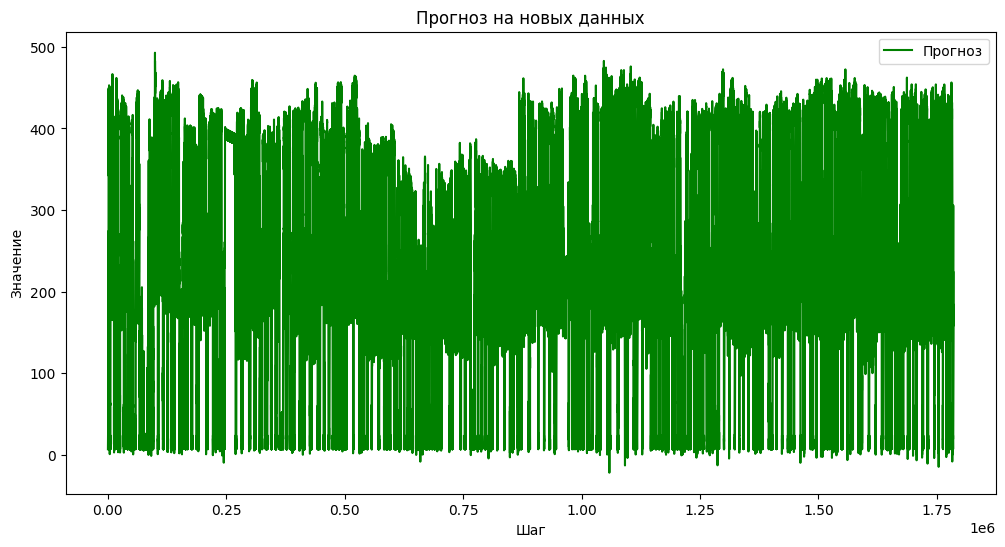

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Глобальная переменная скейлера для нормализации и денормализации
scaler = MinMaxScaler(feature_range=(0, 1))

# Функция нормализации данных
def normalize_data(values):
    """Преобразует данные в диапазон [0, 1]"""
    global scaler
    try:
        # Попытка трансформировать данные
        scaled_values = scaler.transform(values.reshape(-1, 1))
    except AttributeError:
        # Если скейлер не обучен, сначала обучаем его
        if len(values) > 0:
            scaler.fit(values.reshape(-1, 1))
            scaled_values = scaler.transform(values.reshape(-1, 1))
        else:
            raise ValueError("No valid data to scale!")
    return scaled_values.flatten()

# Функция денормализации данных
def denormalize_data(scaled_values):
    """Восстанавливает оригинальные значения из нормализованных"""
    global scaler
    original_values = scaler.inverse_transform(scaled_values.reshape(-1, 1))
    return original_values.flatten()

# Функция подготовки данных
def prepare_data(arr, look_back=10, n_output_steps=120):
    """
    Функция подготовки данных для временного ряда.
    :param arr: Массив временных данных
    :param look_back: Сколько шагов назад смотрит модель
    :param n_output_steps: Сколько шагов вперед прогнозировать
    :return: Входные (X) и выходные (Y) данные
    """
    X, Y = [], []
    for i in range(len(arr)-look_back-n_output_steps+1):
        seq_in = arr[i:i+look_back]
        seq_out = arr[i+look_back:i+look_back+n_output_steps]
        X.append(seq_in)
        Y.append(seq_out)
    return np.array(X), np.array(Y)

# Параметры
look_back = 10                # Количество предыдущих шагов для анализа
n_features = 1                # Признак (одно измерение временного ряда)
lag = 20                      # Текущий лаг для прогнозирования



# Проверка наличия данных
if len(values_new) == 0:
    raise ValueError("Нет данных для прогнозирования!")

# Нормализуем новые данные
scaled_values_new = normalize_data(values_new)

# Готовим данные для прогнозирования
X_new, _ = prepare_data(scaled_values_new, look_back, lag)

# Прогнозируем на новых данных
predictions = model.predict(X_new)

# Денормализуем полученные прогнозы
denormalized_predictions = denormalize_data(predictions.flatten())

# Выводим результаты
plt.figure(figsize=(12, 6))
plt.plot(denormalized_predictions, label="Прогноз", color='green')
plt.xlabel('Шаг')
plt.ylabel('Значение')
plt.title(f'Прогноз на новых данных')
plt.legend()
plt.show()

# Сохраняем прогнозы
np.savetxt('forecasts.txt', denormalized_predictions, fmt='%f')

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


<ipython-input-89-3d576d18a520>:79: RuntimeWarning: divide by zero encountered in divide
  relative_errors_percent = np.where(denormalized_actual != 0, absolute_errors / denormalized_actual * 100, np.nan)


       Факт     Прогноз  Абсолютная ошибка  Относительная ошибка (%)
1200  260.0  251.575043           8.424957                  3.240368
1201  256.0  253.010712           2.989288                  1.167691
1202  259.0  253.370453           5.629547                  2.173570
1203  312.0  253.301331          58.698669                 18.813676
1204  336.0  255.056091          80.943909                 24.090449


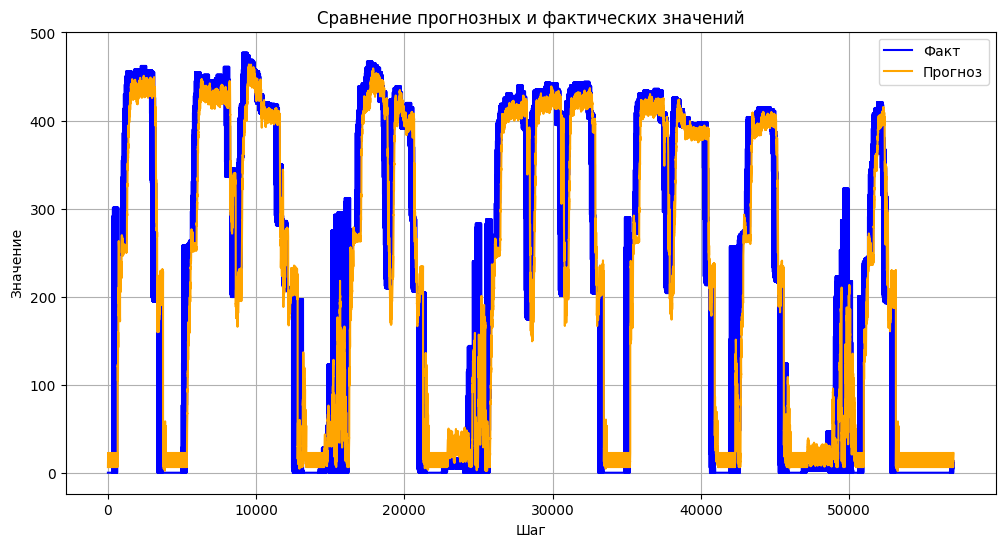

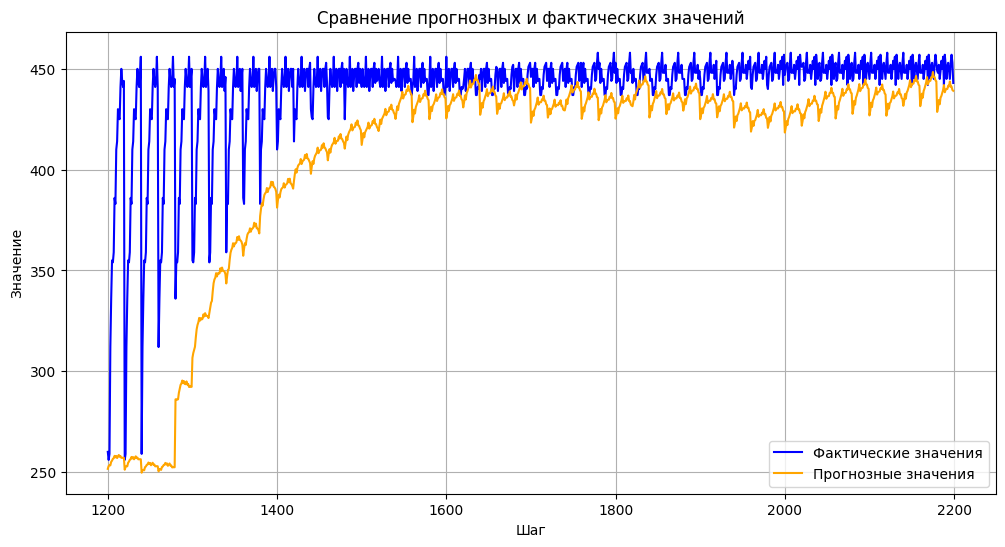

                               Абсолютная ошибка  \
Статистическая характеристика                      
Максимум                              300.026464   
Минимум                                 0.003784   
Среднее                                45.979024   

                               Относительная ошибка (%)\n(среднее по точкам)  
Статистическая характеристика                                                 
Максимум                                                        66684.482366  
Минимум                                                             0.000905  
Среднее                                                           136.233482  


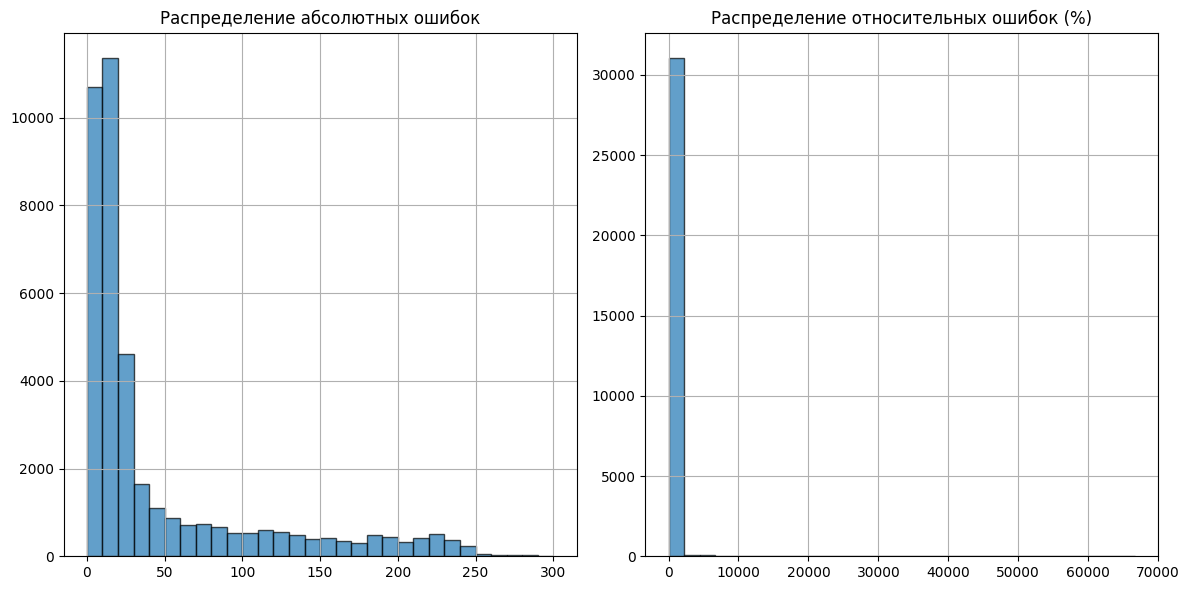

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Глобальная переменная скейлера для нормализации и денормализации
scaler = MinMaxScaler(feature_range=(0, 1))

# Функция нормализации данных
def normalize_data(values):
    """Преобразует данные в диапазон [0, 1]"""
    global scaler
    try:
        # Попытка трансформировать данные
        scaled_values = scaler.transform(values.reshape(-1, 1))
    except AttributeError:
        # Если скейлер не обучен, сначала обучаем его
        if len(values) > 0:
            scaler.fit(values.reshape(-1, 1))
            scaled_values = scaler.transform(values.reshape(-1, 1))
        else:
            raise ValueError("No valid data to scale!")
    return scaled_values.flatten()

# Функция денормализации данных
def denormalize_data(scaled_values):
    """Восстанавливает оригинальные значения из нормализованных"""
    global scaler
    original_values = scaler.inverse_transform(scaled_values.reshape(-1, 1))
    return original_values.flatten()

# Функция подготовки данных
def prepare_data(arr, look_back=10, n_output_steps=120):
    """
    Функция подготовки данных для временного ряда.
    :param arr: Массив временных данных
    :param look_back: Сколько шагов назад смотрит модель
    :param n_output_steps: Сколько шагов вперед прогнозировать
    :return: Входные (X) и выходные (Y) данные
    """
    X, Y = [], []
    for i in range(len(arr)-look_back-n_output_steps+1):
        seq_in = arr[i:i+look_back]
        seq_out = arr[i+look_back:i+look_back+n_output_steps]
        X.append(seq_in)
        Y.append(seq_out)
    return np.array(X), np.array(Y)

# Параметры
look_back = 10                # Количество предыдущих шагов для анализа
n_features = 1                # Признак (одно измерение временного ряда)
lag = 20                      # Текущий лаг для прогнозирования



# Проверка наличия данных
if len(values_new) == 0:
    raise ValueError("Нет данных для прогнозирования!")

# Нормализуем новые данные
scaled_values_new = normalize_data(values_new)

# Готовим данные для прогнозирования
X_new, Y_new = prepare_data(scaled_values_new, look_back, lag)

# Прогнозируем на новых данных
predictions = model.predict(X_new)

# Денормализуем полученные прогнозы
denormalized_predictions = denormalize_data(predictions.flatten())

# Денормализуем фактические значения
denormalized_actual = denormalize_data(Y_new.flatten())

# Рассчитываем ошибки
absolute_errors = abs(denormalized_predictions - denormalized_actual)

# Исключаем деление на ноль при расчёте относительной ошибки
relative_errors_percent = np.where(denormalized_actual != 0, absolute_errors / denormalized_actual * 100, np.nan)

# Собираем данные в DataFrame
comparison_df = pd.DataFrame({
    'Факт': denormalized_actual,
    'Прогноз': denormalized_predictions,
    'Абсолютная ошибка': absolute_errors,
    'Относительная ошибка (%)': relative_errors_percent
})

# Возможность задать начальный индекс и количество выводимых строк
start_idx = 1200    # Начало диапазона
count = 5       # Количество выводимых строк

# Табличное представление
print(comparison_df.iloc[start_idx:start_idx + count])

# Визуализация графика
plt.figure(figsize=(12, 6))
plt.plot(denormalized_actual, label="Факт", color='blue')
plt.plot(denormalized_predictions, label="Прогноз", color='orange')
plt.xlabel('Шаг')
plt.ylabel('Значение')
plt.title(f'Сравнение прогнозных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()


# Визуализация графика с выбором диапазона
plot_start_idx = 1200   # Начало отображаемого диапазона на графике
plot_end_idx = 2200    # Конец отображаемого диапазона на графике


# Визуализация графика
plt.figure(figsize=(12, 6))
plt.plot(range(plot_start_idx, plot_end_idx), comparison_df['Факт'][plot_start_idx:plot_end_idx], label="Фактические значения", color='blue')
plt.plot(range(plot_start_idx, plot_end_idx), comparison_df['Прогноз'][plot_start_idx:plot_end_idx], label="Прогнозные значения", color='orange')
plt.xlabel('Шаг')
plt.ylabel('Значение')
plt.title(f'Сравнение прогнозных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()



# Игнорируем nan-значения при вычислении статистики
valid_abs_errors = abs_errors_stats.dropna()
valid_rel_errors = rel_errors_stats.dropna()

stats_table = pd.DataFrame({
    'Статистическая характеристика': ['Максимум', 'Минимум', 'Среднее'],
    'Абсолютная ошибка': [
        valid_abs_errors.max(),
        valid_abs_errors.min(),
        valid_abs_errors.mean()
    ],
    'Относительная ошибка (%)\n(среднее по точкам)': [
        valid_rel_errors.max(),
        valid_rel_errors.min(),
        valid_rel_errors.mean()
    ]
}).set_index('Статистическая характеристика')

print(stats_table)


# Дополнительная визуализация: гистограмма распределения абсолютных и относительных ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(valid_abs_errors, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение абсолютных ошибок')
axes[0].grid(True)

axes[1].hist(valid_rel_errors, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Распределение относительных ошибок (%)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Сохраняем прогнозы
np.savetxt('forecasts.txt', denormalized_predictions, fmt='%f')

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
                               Абсолютная ошибка  \
Статистическая характеристика                      
Максимум                              300.026464   
Минимум                                 0.003784   
Среднее                                45.356597   

                               Относительная ошибка (%)\n(среднее по точкам)  
Статистическая характеристика                                                 
Максимум                                                          199.679311  
Минимум                                                             0.000905  
Среднее                                                            20.027828  

Количество точек, исключённых из статистики абсолютных ошибок: 0
Количество точек, исключённых из статистики относительных ошибок: 9057


<ipython-input-102-f89ed5919f45>:79: RuntimeWarning: divide by zero encountered in divide
  relative_errors_percent = np.where(denormalized_actual != 0, absolute_errors / denormalized_actual * 100, np.nan)


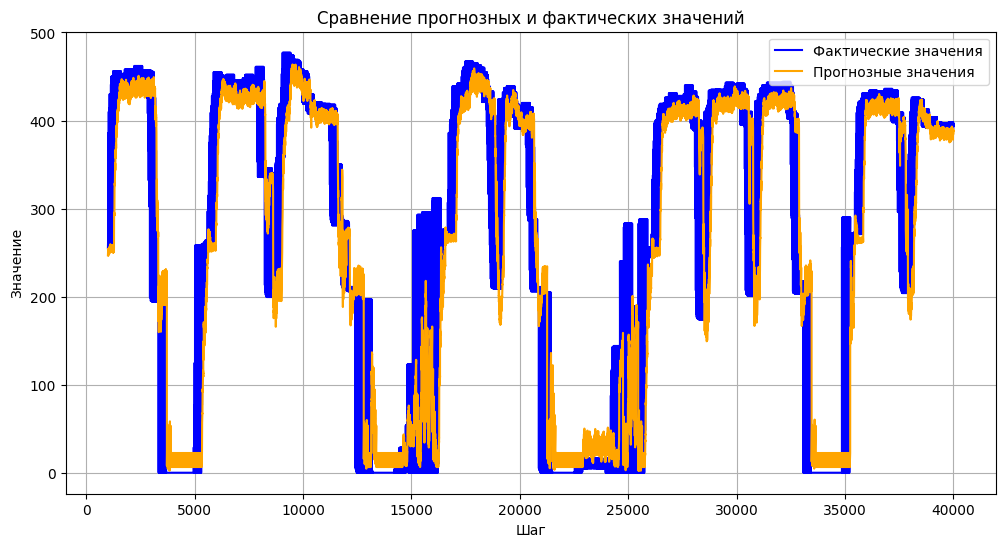

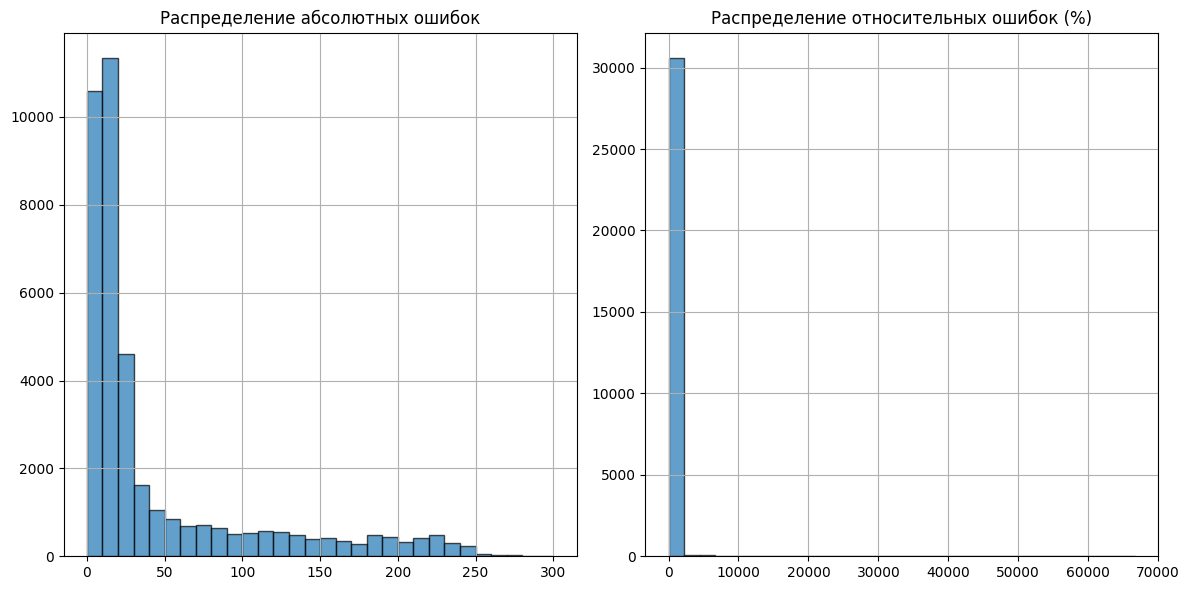

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Глобальная переменная скейлера для нормализации и денормализации
scaler = MinMaxScaler(feature_range=(0, 1))

# Функция нормализации данных
def normalize_data(values):
    """Преобразует данные в диапазон [0, 1]"""
    global scaler
    try:
        # Попытка трансформировать данные
        scaled_values = scaler.transform(values.reshape(-1, 1))
    except AttributeError:
        # Если скейлер не обучен, сначала обучаем его
        if len(values) > 0:
            scaler.fit(values.reshape(-1, 1))
            scaled_values = scaler.transform(values.reshape(-1, 1))
        else:
            raise ValueError("No valid data to scale!")
    return scaled_values.flatten()

# Функция денормализации данных
def denormalize_data(scaled_values):
    """Восстанавливает оригинальные значения из нормализованных"""
    global scaler
    original_values = scaler.inverse_transform(scaled_values.reshape(-1, 1))
    return original_values.flatten()

# Функция подготовки данных
def prepare_data(arr, look_back=10, n_output_steps=120):
    """
    Функция подготовки данных для временного ряда.
    :param arr: Массив временных данных
    :param look_back: Сколько шагов назад смотрит модель
    :param n_output_steps: Сколько шагов вперед прогнозировать
    :return: Входные (X) и выходные (Y) данные
    """
    X, Y = [], []
    for i in range(len(arr)-look_back-n_output_steps+1):
        seq_in = arr[i:i+look_back]
        seq_out = arr[i+look_back:i+look_back+n_output_steps]
        X.append(seq_in)
        Y.append(seq_out)
    return np.array(X), np.array(Y)

# Параметры
look_back = 10                # Количество предыдущих шагов для анализа
n_features = 1                # Признак (одно измерение временного ряда)
lag = 20                      # Текущий лаг для прогнозирования



# Проверка наличия данных
if len(values_new) == 0:
    raise ValueError("Нет данных для прогнозирования!")

# Нормализуем новые данные
scaled_values_new = normalize_data(values_new)

# Готовим данные для прогнозирования
X_new, Y_new = prepare_data(scaled_values_new, look_back, lag)

# Прогнозируем на новых данных
predictions = model.predict(X_new)

# Денормализуем полученные прогнозы
denormalized_predictions = denormalize_data(predictions.flatten())

# Денормализуем фактические значения
denormalized_actual = denormalize_data(Y_new.flatten())

# Рассчитываем ошибки
absolute_errors = abs(denormalized_predictions - denormalized_actual)

# Исключаем деление на ноль при расчёте относительной ошибки
relative_errors_percent = np.where(denormalized_actual != 0, absolute_errors / denormalized_actual * 100, np.nan)

# Собираем данные в DataFrame
comparison_df = pd.DataFrame({
    'Факт': denormalized_actual,
    'Прогноз': denormalized_predictions,
    'Абсолютная ошибка': absolute_errors,
    'Относительная ошибка (%)': relative_errors_percent
})

# Возможность задать начальный индекс и количество выводимых строк
start_idx = 1200    # Начало диапазона
count = 5       # Количество выводимых строк

# Статистика по указанному диапазону
selected_range = comparison_df.iloc[plot_start_idx:plot_end_idx]
abs_errors_stats = selected_range['Абсолютная ошибка']
rel_errors_stats = selected_range['Относительная ошибка (%)']


# Визуализация графика с выбором диапазона
plot_start_idx = 1000   # Начало отображаемого диапазона на графике
plot_end_idx = 40000    # Конец отображаемого диапазона на графике

# Статистика по указанному диапазону
selected_range = comparison_df.iloc[plot_start_idx:plot_end_idx]
abs_errors_stats = selected_range['Абсолютная ошибка']
rel_errors_stats = selected_range['Относительная ошибка (%)']

# Установка верхних порогов для абсолютных и относительных ошибок
upper_threshold_abs = 600  # Верхний порог для абсолютных ошибок
upper_threshold_rel = 200  # Верхний порог для относительных ошибок

# Фильтруем данные: оставляем только ошибки ниже установленных порогов
filtered_abs_errors = abs_errors_stats[abs_errors_stats < upper_threshold_abs]
filtered_rel_errors = rel_errors_stats[rel_errors_stats < upper_threshold_rel]

# Количество исключённых точек
excluded_points_abs = len(abs_errors_stats) - len(filtered_abs_errors)
excluded_points_rel = len(rel_errors_stats) - len(filtered_rel_errors)


# Статистика после исключения выбросов
stats_table = pd.DataFrame({
    'Статистическая характеристика': ['Максимум', 'Минимум', 'Среднее'],
    'Абсолютная ошибка': [
        filtered_abs_errors.max(),
        filtered_abs_errors.min(),
        filtered_abs_errors.mean()
    ],
    'Относительная ошибка (%)\n(среднее по точкам)': [
        filtered_rel_errors.max(),  # Тут используем отфильтрованные относительные ошибки
        filtered_rel_errors.min(),
        filtered_rel_errors.mean()
    ]
}).set_index('Статистическая характеристика')

print(stats_table)

# Информация о количестве исключённых точек
print(f'\nКоличество точек, исключённых из статистики абсолютных ошибок: {excluded_points_abs}')
print(f'Количество точек, исключённых из статистики относительных ошибок: {excluded_points_rel}')

# Визуализация графика
plt.figure(figsize=(12, 6))
plt.plot(range(plot_start_idx, plot_end_idx), comparison_df['Факт'][plot_start_idx:plot_end_idx], label="Фактические значения", color='blue')
plt.plot(range(plot_start_idx, plot_end_idx), comparison_df['Прогноз'][plot_start_idx:plot_end_idx], label="Прогнозные значения", color='orange')
plt.xlabel('Шаг')
plt.ylabel('Значение')
plt.title(f'Сравнение прогнозных и фактических значений')
plt.legend()
plt.grid(True)
plt.show()

# Дополнительная визуализация: гистограмма распределения абсолютных и относительных ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hist(filtered_abs_errors, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение абсолютных ошибок')
axes[0].grid(True)

axes[1].hist(rel_errors_stats.dropna(), bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('Распределение относительных ошибок (%)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Сохраняем прогнозы
np.savetxt('forecasts.txt', denormalized_predictions, fmt='%f')

# # Обучение на полном ряде лаговых сдвигов вперёд

In [ ]:
# Ограничиваем диапазон дат
start_date = '2024-06-01'
end_date = '2024-10-01'

# Ограничиваем датасет периодом обучения
df = df[(df['source_time'] >= start_date) & (df['source_time'] <= end_date)]

# Удаляем столбец 'mode' и назначаем целевую переменную 'value_14'
#df = df.drop(columns=['mode'])


# Основные настройки
look_back = 20            # Сколько шагов назад смотрим
n_features = 1            # Всего один признак (одно измерение временного ряда)
lags = [20, 30, 40, 60, 90, 120]  # Лаги для экспериментов
#lags = [20]

# Определяем целевую переменную
values = df["value_14"].values

# Нормализация данных
scaled_values = normalize_data(values)

In [ ]:
# Эксперименты по разным величинам лагов
for lag in lags:
    print(f"\n\n===== Эксперимент с лагом {lag} =====")

    # Подготовим данные
    X, Y = prepare_data(scaled_values, look_back, lag)

    # Деление на обучающую и проверочную выборки
    split_point = int(len(X)*0.8)
    X_train, X_val = X[:split_point], X[split_point:]
    Y_train, Y_val = Y[:split_point], Y[split_point:]
    print("\nShapes before training:")
    print("X_train:", X_train.shape)
    print("Y_train:", Y_train.shape)
    print("X_val:", X_val.shape)
    print("Y_val:", Y_val.shape)

    # Создадим модель
    model = create_attention_model(look_back, n_features, lag)

    # Настроим раннюю остановку
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Обучение модели
    history = model.fit(
        X_train, Y_train,
        epochs=50,
        batch_size=64,
        validation_data=(X_val, Y_val),
        callbacks=[early_stopping],
        verbose=1
    )

    # Прогноз и визуализация
    predictions = model.predict(X_val[:10])
    print("\nShapes after prediction:")
    print("Predictions:", predictions.shape)
    for idx in range(min(5, len(predictions))):
        true_values = Y_val[idx].flatten()
        pred_values = predictions[idx].flatten()

        # Возвращаем к оригинальной шкале
        true_denorm = denormalize_data(true_values)
        pred_denorm = denormalize_data(pred_values)

        plt.figure(figsize=(12, 6))
        plt.plot(true_denorm, label=f'Истинные ({lag}-лаги)', color='blue')
        plt.plot(pred_denorm, label=f'Прогноз ({lag}-лаги)', color='orange')
        plt.xlabel('Шаг')
        plt.ylabel('Значение')
        plt.title(f'Пример {idx}: Лаг {lag}')
        plt.legend()
        plt.show()

    # Оценка точности
    predicted_values = model.predict(X_val)
    print("\nFinal evaluation shapes:")
    print("Y_val flattened:", Y_val.flatten().shape)
    print("Predicted values flattened:", predicted_values.flatten().shape)
    mae_score = mean_absolute_error(denormalize_data(Y_val.flatten()), denormalize_data(predicted_values.flatten()))
    print(f"Среднее абсолютное отклонение (MAE) для лагов {lag}: {mae_score:.4f}\n")



===== Эксперимент с лагом 20 =====

Shapes before training:
X_train: (281057, 20)
Y_train: (281057, 20)
X_val: (70265, 20)
Y_val: (70265, 20)
Epoch 1/50
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 279s 62ms/step - loss: 0.0196 - mae: 0.0812 - val_loss: 0.0213 - val_mae: 0.0890
Epoch 2/50
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 272s 62ms/step - loss: 0.0151 - mae: 0.0702 - val_loss: 0.0204 - val_mae: 0.0894
Epoch 3/50
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 323s 62ms/step - loss: 0.0147 - mae: 0.0692 - val_loss: 0.0201 - val_mae: 0.0792
Epoch 4/50
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 319s 61ms/step - loss: 0.0145 - mae: 0.0680 - val_loss: 0.0198 - val_mae: 0.0804
Epoch 5/50
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 274s 62ms/step - loss: 0.0142 - mae: 0.0671 - val_loss: 0.0197 - val_mae: 0.0727
Epoch 6/50
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 343s 67ms/step - loss: 0.0140 - mae: 0.0664 - val_loss: 0.0195 - val_mae: 0.0788
Epoch 7/50
4392/4392 ━━━━━━━━━━━━━━━━━━━━ 307s 64ms/step - loss: 0.0139 - mae: 0.0657 - val_loss: 0.0196 - val_mae: 0.